# Importing Modules

In [2]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define Neural Network

In [3]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Advection equation 

$ -\left( v(x) \frac{\partial u}{\partial x} + v(y) \frac{\partial u}{\partial y} \right)$


In [4]:
mu = 0.1 
def u0(x):
    return np.exp(-100*(x-0.2)**2) # gaussian wave
def u_true(x,t):
    return  u0(x - mu * t)

# 2D advection equation 
def u_2d_true(x, y, t):
        return u0(x - mu * t) * u0(y - mu * t)

# Observational input Data

In [30]:
nx,ny,nt = 10,10,2

xrmeshshape: (10, 10, 2) 
 yrmeshshape: (10, 10, 2) 
 trmeshshape: (10, 10, 2)


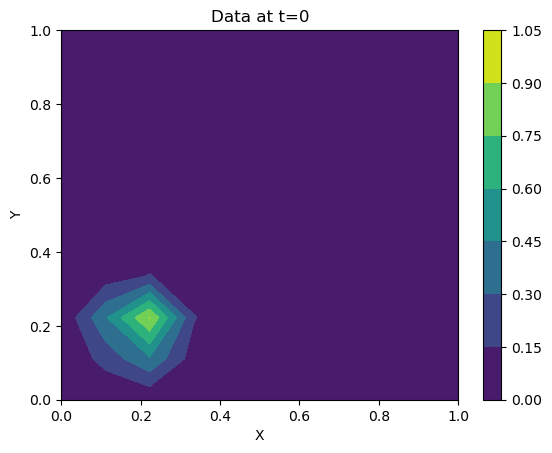

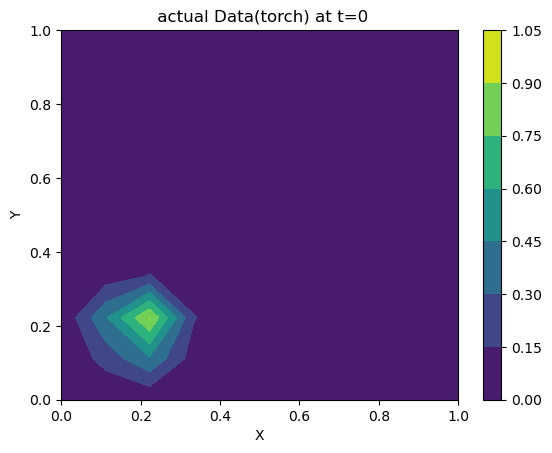

rin_data shape: torch.Size([200, 3]) 
 rout_data shape: torch.Size([200, 1])


In [31]:
xr = np.linspace(0,1,nx)
yr = np.linspace(0,1,ny)
tr = np.linspace(0,nt-1,nt).T
# print(f'xr: {xr} \n yr: {yr} \n tr: {tr}')
# print(f'xrshape: {xr.shape} \n yrshape: {yr.shape} \n trshape: {tr.shape}')
xrmesh , yrmesh, trmesh = np.meshgrid(xr,yr,tr)
# print(f'xrmesh: {xrmesh} \n yrmesh: {yrmesh} \n trmesh: {trmesh}')
print(f'xrmeshshape: {xrmesh.shape} \n yrmeshshape: {yrmesh.shape} \n trmeshshape: {trmesh.shape}')

ur = u_2d_true(xrmesh,yrmesh,trmesh)

#print(ur[:,:,0].shape)
# print(ur[0,:,:].shape)
# print(xrmesh[0,:,:].shape)
#plot ur
plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ur[:,:,0])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data at t=0')
plt.colorbar()
plt.show()

# Stack the 3 2D arrays along a new third dimension, then reshape into a 2D array
rin_data = np.stack((xrmesh, yrmesh, trmesh), axis=-1).reshape(-1, 3)
rin_data = torch.tensor(rin_data).float()
rout_data = torch.tensor(ur).float().reshape(-1,1)

rout_data2 = rout_data.numpy().reshape(nx,ny,nt)
plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], rout_data2[:,:,0])
plt.xlabel('X')
plt.ylabel('Y')
plt.title(' actual Data(torch) at t=0')
plt.colorbar()
plt.show()
print(f'rin_data shape: {rin_data.shape} \n rout_data shape: {rout_data.shape}')

# Fitting a Neural Network to the observational data

In [32]:
torch.manual_seed(123)
model = FCN(3,1,32,3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for i in range(5000):
    optimizer.zero_grad()
    uh = model(rin_data)
    
    loss = torch.mean((uh-rout_data)**2)
    loss.backward()
    optimizer.step()
    if (i+1) % 1000 == 0:
        print(f'Epoch: {i+1}/{10000}, Loss: {loss.item()}')
        

print(uh.shape, rout_data.shape, rin_data.shape)

Epoch: 1000/10000, Loss: 0.00371599942445755
Epoch: 2000/10000, Loss: 4.03662197641097e-05
Epoch: 3000/10000, Loss: 1.0205385478911921e-05
Epoch: 4000/10000, Loss: 5.6598255468998104e-06
Epoch: 5000/10000, Loss: 3.5426210160949267e-06
torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 3])


To check the behavior of the fitted model, we plot model output as a function of x and y for times between t=0 and t=3, and compare it to observed data and the true function.

torch.Size([400, 1])


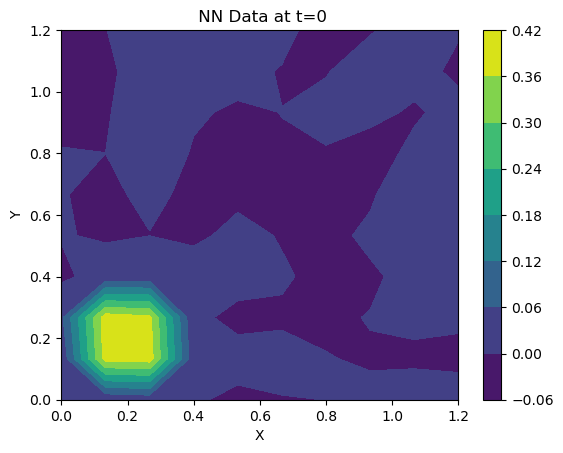

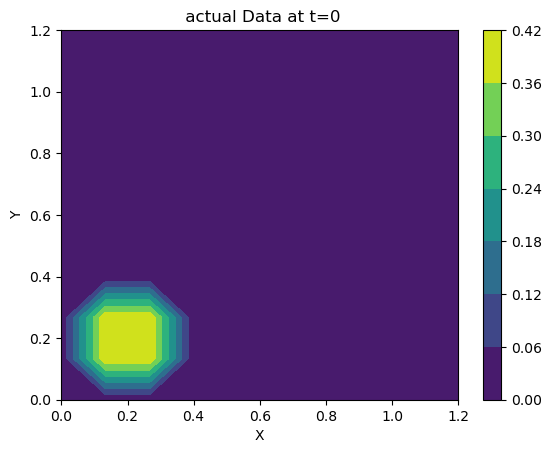

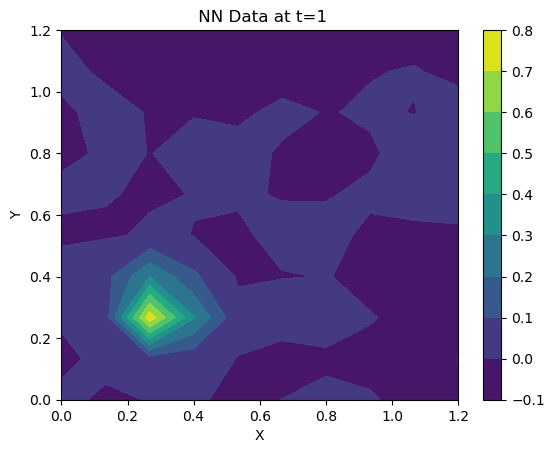

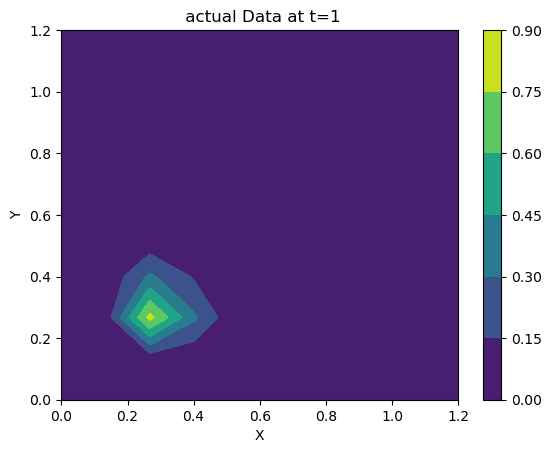

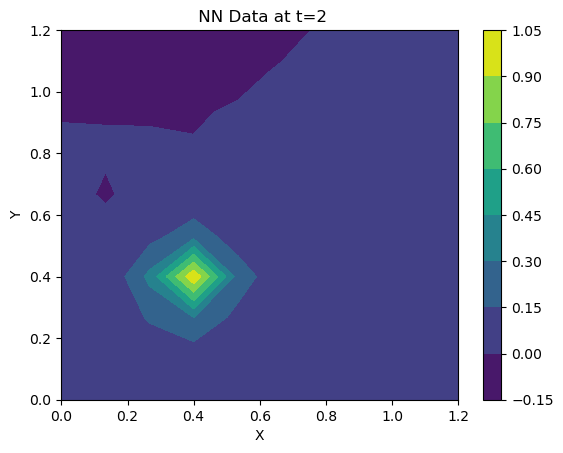

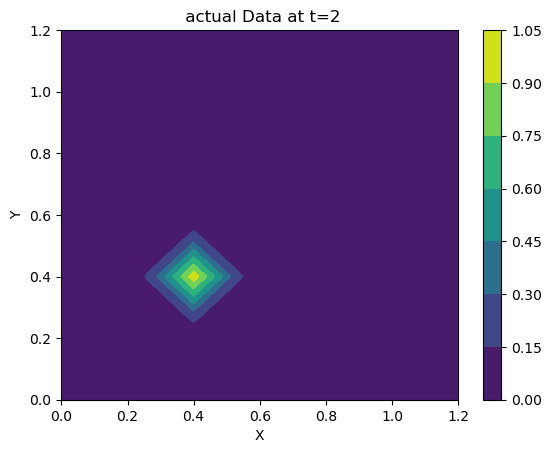

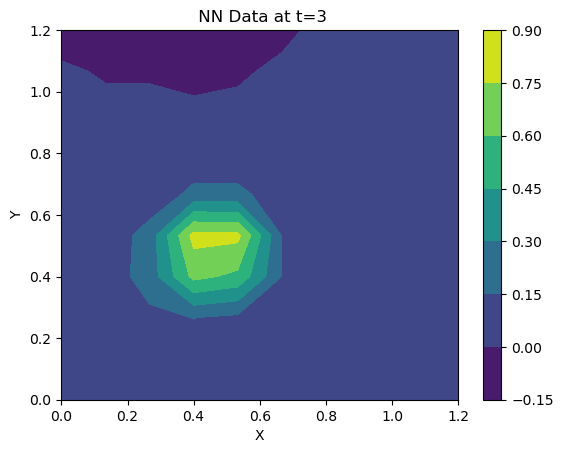

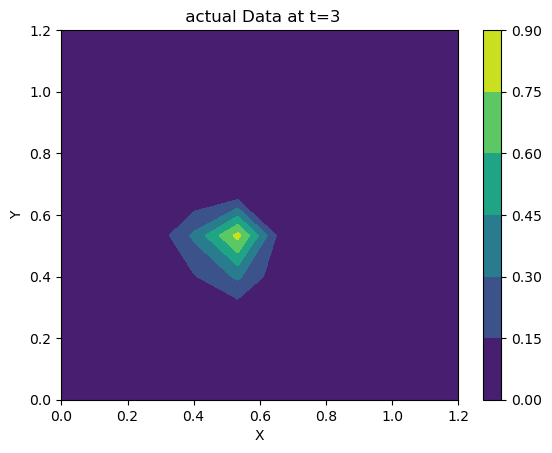

In [33]:
nt = 4
xr = np.linspace(0,1.2,nx)
yr = np.linspace(0,1.2,ny)
tr = np.linspace(0,nt-1,nt).T
# print(f'xr: {xr} \n yr: {yr} \n tr: {tr}')
# print(f'xrshape: {xr.shape} \n yrshape: {yr.shape} \n trshape: {tr.shape}')
xrmesh , yrmesh, trmesh = np.meshgrid(xr,yr,tr)
# print(f'xrmesh: {xrmesh} \n yrmesh: {yrmesh} \n trmesh: {trmesh}')
#print(f'xrmeshshape: {xrmesh.shape} \n yrmeshshape: {yrmesh.shape} \n trmeshshape: {trmesh.shape}')


rin_test = np.stack((xrmesh, yrmesh, trmesh), axis=-1).reshape(-1, 3)
rin_test = torch.tensor(rin_test).float()
print(model(rin_test.float()).shape)

for tt in range(4):
    ur = model(rin_test.float()).detach().numpy().reshape(nx,ny,nt)
    ut = u_2d_true(xrmesh,yrmesh,trmesh)
    plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ur[:,:,tt])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(' NN Data at t='+str(tt))
    plt.colorbar()
    plt.show()

    plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ut[:,:,tt])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(' actual Data at t='+str(tt))
    plt.colorbar()
    plt.show()




# Adding physics to the loss function

We generate a random selection of points over that (x,y)-t domain $(0,1) \times (0,5)$ at which the physical constraint will be enforced.

In [37]:
# nx,ny,nt = 10,10,2
nx,ny,nt = 10,10,2


# randomly sample points in (x,y)-t space, where x in [0,1] and t in [0,5]
np.random.seed(123)
rin_physics = np.random.uniform(size=(nx*ny*nt,3))
rin_physics[:,2] *= nt
rin_physics = torch.tensor(rin_physics).float().requires_grad_(True)
print(f'input tensor shape :{rin_data.shape}')
print(f'input tensor physics shape : {rin_physics.shape}')

# Input observations to the network : rin_data

xr = np.linspace(0,1,nx)
yr = np.linspace(0,1,ny)
tr = np.linspace(0,nt-1,nt).T
# print(f'xr: {xr} \n yr: {yr} \n tr: {tr}')
# print(f'xrshape: {xr.shape} \n yrshape: {yr.shape} \n trshape: {tr.shape}')
xrmesh , yrmesh, trmesh = np.meshgrid(xr,yr,tr)
# print(f'xrmesh: {xrmesh} \n yrmesh: {yrmesh} \n trmesh: {trmesh}')
print(f'xrmeshshape: {xrmesh.shape} \n yrmeshshape: {yrmesh.shape} \n trmeshshape: {trmesh.shape}')

ur = u_2d_true(xrmesh,yrmesh,trmesh)

#print(ur[:,:,0].shape)
# print(ur[0,:,:].shape)
# print(xrmesh[0,:,:].shape)

# Stack the 3 2D arrays along a new third dimension, then reshape into a 2D array
rin_data = np.stack((xrmesh, yrmesh, trmesh), axis=-1).reshape(-1, 3)
rin_data = torch.tensor(rin_data).float()


input tensor shape :torch.Size([200, 3])
input tensor physics shape : torch.Size([200, 3])
xrmeshshape: (10, 10, 2) 
 yrmeshshape: (10, 10, 2) 
 trmeshshape: (10, 10, 2)


# Fitting a PINN 

In [40]:
torch.manual_seed(123)
pinn = FCN(3,1,32,3)
#mu = torch.tensor(np.linspace(0.1, 0.5, 100).reshape(100,1)).float()
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
for i in range(5000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    uh = pinn(rin_data)
    loss1 = torch.mean((uh-rout_data)**2) # use mean squared error
    
    # compute the "physics loss"
    uhp = pinn(rin_physics)
    grad = torch.autograd.grad(outputs=uhp, inputs=rin_physics, 
                               grad_outputs=torch.ones_like(uhp), create_graph=True)[0]
    dudx = grad[:, 0]
    dudy = grad[:, 1]
    dudt = grad[:, 2]
    physics = dudt + mu *( dudx + dudy) # this term is zero if the model output satisfies the advection equation
    loss2 = torch.mean((physics)**2)
    
    # backpropagate combined loss
    loss = 2*loss1 + loss2 # add two loss terms together
    loss.backward()
    optimizer.step()

    if (i+1) % 1000 == 0:
            print(f'Epoch: {i+1}/{10000}, Loss: {loss.item()}')
            print(f' NN loss : {loss1.item()}, Physics loss : {loss2.item()}')

Epoch: 1000/10000, Loss: 0.012490537948906422
 NN loss : 0.0061985705979168415, Physics loss : 9.339632379123941e-05
Epoch: 2000/10000, Loss: 0.00015871583309490234
 NN loss : 6.487421342171729e-05, Physics loss : 2.8967406251467764e-05
Epoch: 3000/10000, Loss: 4.474317029234953e-05
 NN loss : 1.855154005170334e-05, Physics loss : 7.640091098437551e-06
Epoch: 4000/10000, Loss: 3.096570435445756e-05
 NN loss : 1.3187402146286331e-05, Physics loss : 4.590901426126948e-06
Epoch: 5000/10000, Loss: 1.84842137969099e-05
 NN loss : 7.57409952711896e-06, Physics loss : 3.3360140605509514e-06


To check the behavior of the fitted model, we plot model output as a function of x and y for times between t=0 and t=3, and compare it to observed data and the true function.

torch.Size([400, 1])


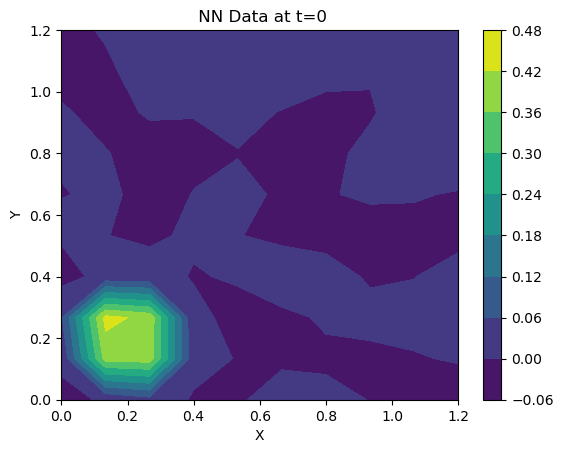

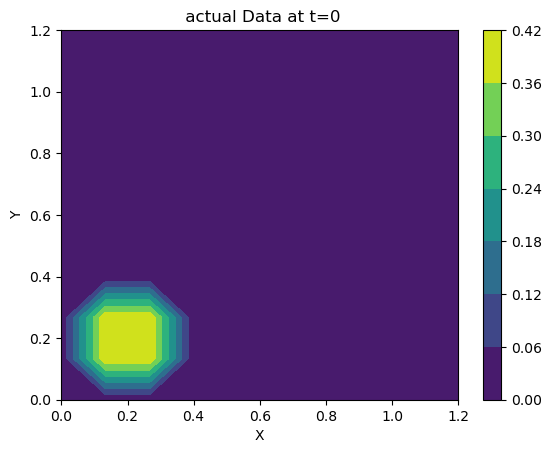

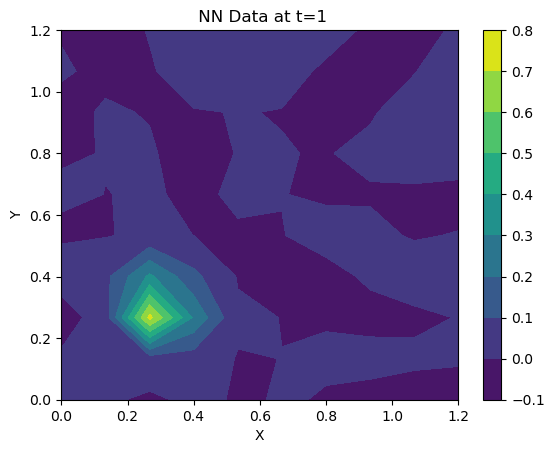

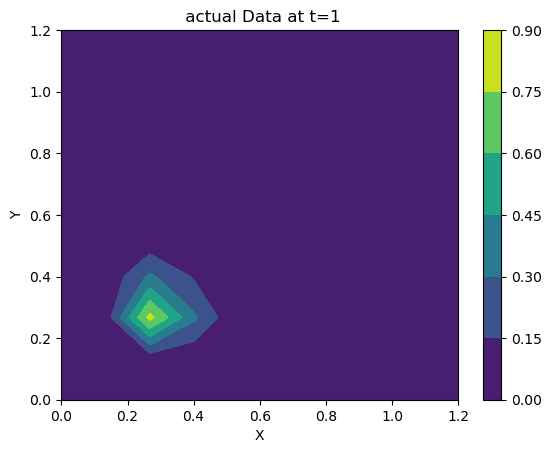

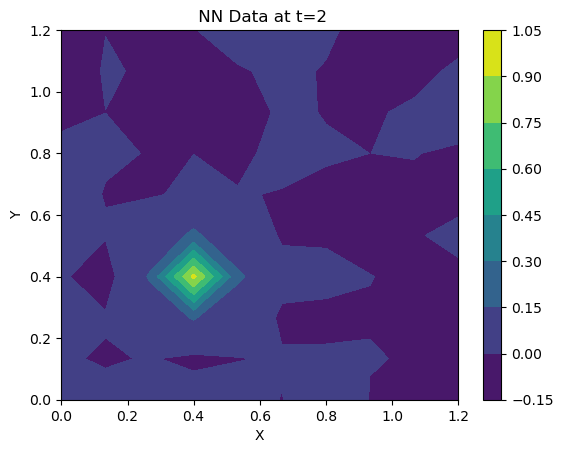

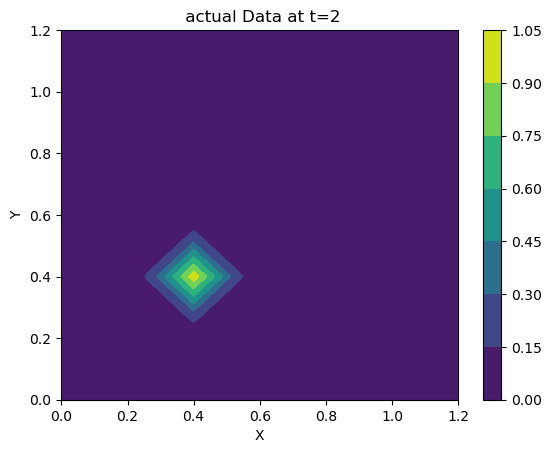

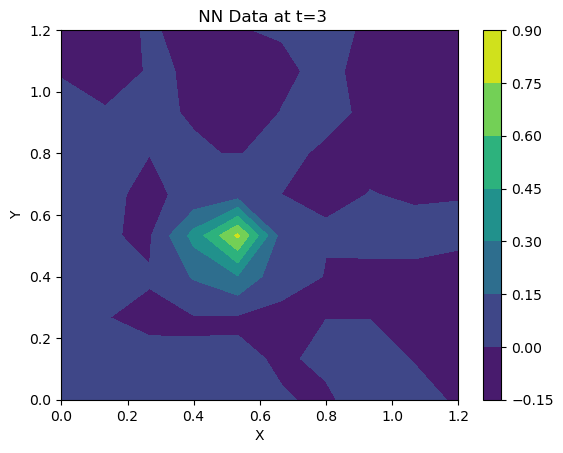

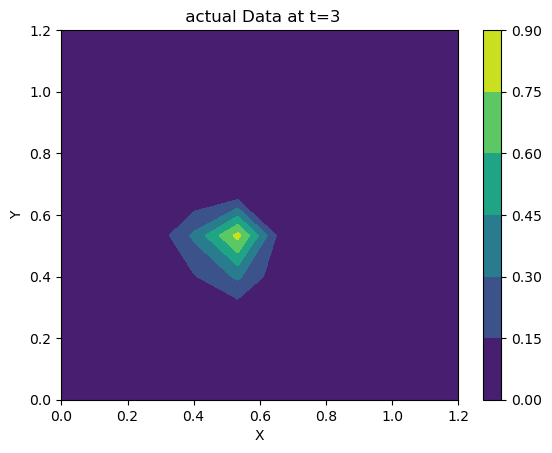

In [41]:
nt = 4
xr = np.linspace(0,1.2,nx)
yr = np.linspace(0,1.2,ny)
tr = np.linspace(0,nt-1,nt).T
# print(f'xr: {xr} \n yr: {yr} \n tr: {tr}')
# print(f'xrshape: {xr.shape} \n yrshape: {yr.shape} \n trshape: {tr.shape}')
xrmesh , yrmesh, trmesh = np.meshgrid(xr,yr,tr)
# print(f'xrmesh: {xrmesh} \n yrmesh: {yrmesh} \n trmesh: {trmesh}')
#print(f'xrmeshshape: {xrmesh.shape} \n yrmeshshape: {yrmesh.shape} \n trmeshshape: {trmesh.shape}')


rin_test = np.stack((xrmesh, yrmesh, trmesh), axis=-1).reshape(-1, 3)
rin_test = torch.tensor(rin_test).float()
print(model(rin_test.float()).shape)

for tt in range(4):
    ur = pinn(rin_test.float()).detach().numpy().reshape(nx,ny,nt)
    ut = u_2d_true(xrmesh,yrmesh,trmesh)
    plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ur[:,:,tt])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(' NN Data at t='+str(tt))
    plt.colorbar()
    plt.show()

    plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ut[:,:,tt])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(' actual Data at t='+str(tt))
    plt.colorbar()
    plt.show()


